In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import networkx as nx
import pandas as pd

In [439]:
data_directory = '../../data/experiment_verysmall/'
data = np.load(data_directory + 'network_params/data_network.npy')
data = np.transpose(data, (1, 2, 0))
data.shape

(2, 2801, 2)

In [479]:
F = 250
start = 750

S = data[:,start:start+F,0]
D = data[:,start:start+F,1]

S[1], D[1] = np.copy(D[1]), np.copy(S[1])

N = len(S)
b_max = np.array([2000, 1000])
b_init = np.zeros(N)
Q_max = 10

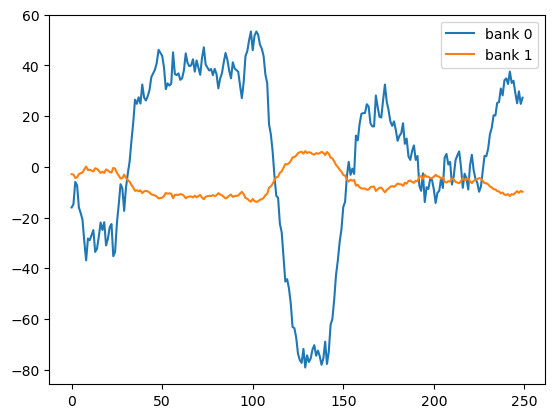

In [480]:
plt.plot((S-D)[0], label = 'bank 0')
plt.plot((S-D)[1], label = 'bank 1')
plt.legend()

In [486]:
B = cp.Variable([N,F+1])
Q = cp.Variable([N,N,F])
M = cp.Variable([N,F])

neg_pen = 0.1

obj_func = 1/(N*F)*cp.sum([cp.norm(cp.pos(m_k) + neg_pen*cp.neg(m_k),1) for m_k in M])
obj = cp.Minimize(obj_func)

constr =  []

# IC
constr += [B[:,0] == np.zeros(N)]
# constr += [M>=0]


# max storage
for t in range(F+1):
    constr +=[B[:,t]<=b_max]
    
# dynamics    
for t in range(F):
    for k in range(N):
        constr += [B[k,t+1] == B[k,t] + S[k,t] - D[k,t] + cp.sum(Q[k,:,t])+ M[k,t]]

# storage constraints
for t in range(F+1):
    constr +=[0<= B[:,t]]


##### shipments
for k in range(N):
    for l in range(N):
        constr +=[Q[k,l] == -Q[l,k]]

for k in range(N):
    for t in range(F):
        constr += [cp.sum(Q[:,k,t]) <= B[k,t]]

constr += [cp.norm(Q,'inf') <= Q_max]

prob = cp.Problem(obj,constr)
prob.solve()
print(prob.value)
Q_opt = Q.value
B_opt = B[:,1:].value
M_opt = M.value

2.0937823049689257


In [487]:
# plt.plot(B_opt[0], label = 'b_o')
#plt.plot(np.cumsum(S[0]-D[0]), label = 'true diff bank 0')
#plt.plot(np.cumsum(S[1]-D[1]), label = 'true diff bank 1')
#plt.plot(Q_opt[0,1], label = 'bank 1 to bank 0')
#plt.legend()

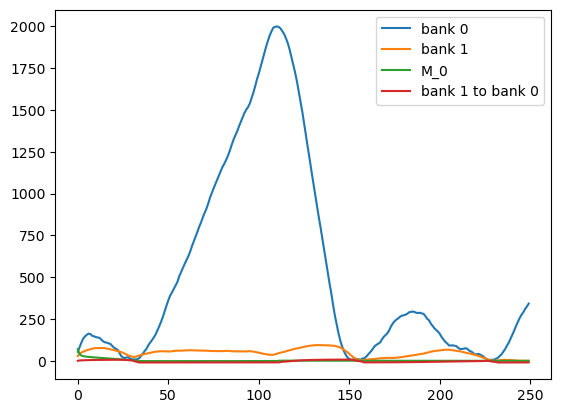

In [488]:
plt.plot(B_opt[0], label = 'bank 0')
plt.plot(B_opt[1], label = 'bank 1')
plt.plot(M_opt[0], label = 'M_0')
plt.plot(Q_opt[0,1], label = 'bank 1 to bank 0')
plt.legend()

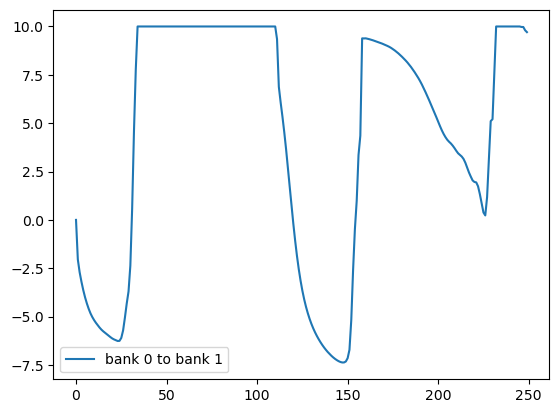

In [489]:
plt.plot(Q_opt[1,0], label = 'bank 0 to bank 1')
plt.legend()

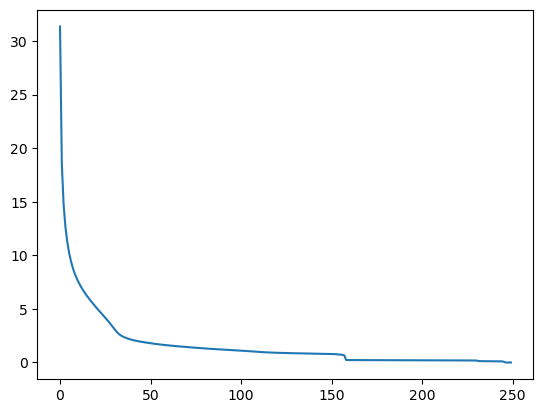

In [490]:
plt.plot(M_opt[1])